In [61]:
import math
import torch
import numpy as np
import gpytorch
import pandas as pd
import seaborn as sns
import os
import pickle
import matplotlib 
matplotlib.use('Agg')
from matplotlib import pyplot as plt
import sklearn
from sklearn.model_selection import KFold

%matplotlib inline
# %load_ext autoreload
# %autoreload 2
%reload_ext autoreload
import imblearn as imb
# print("imblearn version: ",imblearn.__version__)
from imblearn.over_sampling import SMOTE

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

from sklearn.metrics import confusion_matrix
import itertools

from scipy.stats import randint
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import accuracy_score, precision_score, f1_score, roc_auc_score, roc_curve, precision_recall_curve, auc, recall_score

from sklearn.ensemble import RandomForestClassifier
from imblearn.ensemble import BalancedRandomForestClassifier
from rdkit import Chem
from rdkit.Chem import Draw
import sys
sys.path.append('../')
import utils
from sklearn.model_selection import GridSearchCV
from VisUtils import *
from split_data import *
from RF_GSCV import *
from RF_Utils import *


# Load binding data 

In [59]:
split_path = '../../../../data/NEK_data_4Berkeley/NEK2/'
# train_x_df = pd.read_csv(split_path+"/NEK2_binding_random_fold1_trainX.csv")
# train_y_df= pd.read_csv(split_path+"/NEK2_binding_random_fold1_trainY.csv")
# test_x_df= pd.read_csv(split_path+"/NEK2_binding_random_fold1_testX.csv")
# test_y_df= pd.read_csv(split_path+"/NEK2_binding_random_fold1_testY.csv")
# train_x = torch.from_numpy(train_x_df.to_numpy())
# train_y = torch.from_numpy(train_y_df.to_numpy().reshape(-1))
# test_x = torch.from_numpy(test_x_df.to_numpy())
# test_y = torch.from_numpy(test_y_df.to_numpy().reshape(-1))


In [57]:
train_x_df.columns

Index(['ASA+_per_atom', 'ASA-', 'ASA_H_per_atom', 'ASA_P', 'ASA_per_atom',
       'BCUT_PEOE_0', 'BCUT_PEOE_1', 'BCUT_PEOE_2', 'BCUT_PEOE_3',
       'BCUT_SLOGP_0_per_atom',
       ...
       'vsurf_Wp2_per_atom', 'vsurf_Wp3', 'vsurf_Wp4', 'vsurf_Wp5',
       'vsurf_Wp6', 'vsurf_Wp7', 'vsurf_Wp8', 'weinerPath',
       'weinerPol_per_atom', 'zagreb_per_atom'],
      dtype='object', length=306)

In [60]:
# # Scale data
# x_df = pd.concat([train_x_df, test_x_df])

# scaling=StandardScaler()
 
# # Use fit and transform method 
# scaling.fit(x_df)
# Scaled_data=scaling.transform(x_df)
# train_x = scaling.transform(train_x_df)
# test_x = scaling.transform(test_x_df) 

# train_y = train_y_df.to_numpy().flatten()
# test_y = test_y_df.to_numpy().flatten()


In [53]:
# back to df for saving 
# train_x_df = pd.DataFrame(train_x) 
# train_y_df = pd.DataFrame(train_y) 
# test_y_df = pd.DataFrame(test_y)
# test_x_df = pd.DataFrame(test_x)

# train_x_df.to_csv(split_path+'bind_train_x_scaledoriginal.csv', index=False, header=False)
# train_y_df.to_csv(split_path+'bind_train_y_scaledoriginal.csv', index=False, header=False) 
# test_y_df.to_csv(split_path+'bind_test_y_scaledoriginal.csv', index=False, header=False) 
# test_x_df.to_csv(split_path+'bind_test_x_scaledoriginal.csv', index=False, header=False) 
# print(train_x_df.shape, train_y_df.shape, test_y_df.shape, test_x_df.shape)


train_x_df = pd.read_csv(split_path+"/bind/bind_train_x_scaledoriginal.csv")

train_y_df= pd.read_csv(split_path+"/bind/bind_train_y_scaledoriginal.csv")
test_x_df= pd.read_csv(split_path+"/bind/bind_test_x_scaledoriginal.csv")
test_y_df= pd.read_csv(split_path+"/bind/bind_test_y_scaledoriginal.csv")
train_x = train_x_df.values
train_y = train_y_df.values.reshape(-1)  
test_x = test_x_df.values
test_y = test_y_df.values.reshape(-1)  

train_x.shape, train_y.shape, test_x.shape, test_y.shape

((1124, 306), (1124,), (282, 306), (282,))

In [54]:
train_x_df

,6.171916274709142,-2.8806660841766516,-0.24281959826384064,-0.138540075570739,3.1740183690503954,1.664387025213973,2.9566067521703463,-2.7765260689251936,-1.8737027449594563,-6.03021769571616,...,3.4686203569517193,-0.8681549182514628,-0.1435906749360727,-0.06567359356513179,-0.05894711820376917,-0.1836572498800206,-0.20696947261167276,-1.235610383485261,-0.816892102458589,0.1941642587640052
0,0.504051,0.725849,-0.489283,1.847024,0.319364,-0.163025,-0.395619,0.682256,0.269110,-0.059029,...,0.992820,1.502885,0.973047,0.809867,0.211529,-0.291313,-0.206969,0.257966,-0.011573,-0.539664
1,-1.005664,1.857896,-0.732021,1.562579,-0.222465,-0.258641,0.555600,-0.776457,0.794523,0.996309,...,-1.184218,-0.544634,-0.283901,-0.277498,-0.445342,-0.398969,-0.206969,0.769733,1.066145,0.502085
2,-0.272463,0.356568,-0.742466,1.119058,0.391476,0.992658,-0.464873,0.315869,0.916609,0.039975,...,0.588559,0.358619,-0.266362,-0.291620,-0.445342,-0.398969,-0.206969,-0.450504,0.540647,1.080537
3,1.507075,-0.643926,1.305948,-0.705561,1.121426,1.445349,0.459030,1.731704,-1.692399,-0.232629,...,1.382426,0.065496,-0.026665,-0.023309,0.018332,0.031654,-0.206969,-0.736191,-0.070246,0.125982
4,1.470831,-1.478225,-0.400701,0.358067,-0.152172,-0.353619,0.982186,-0.474092,-0.014664,-1.109815,...,1.328558,1.911086,1.762293,1.445341,0.791121,0.031654,-0.206969,-0.596966,-0.436781,-1.101303
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1119,-0.457462,0.807091,-0.506839,0.964598,0.185155,-0.649355,2.715022,-2.853578,0.158251,0.031003,...,-1.268711,-1.228588,-1.517464,-1.477836,-1.218131,-0.398969,-0.206969,-0.281476,0.866456,0.371439
1120,-0.372155,0.557003,-1.156730,1.663079,-0.809002,-1.417213,1.321758,-0.682036,1.251613,0.203225,...,-0.318807,1.450774,1.259514,1.162908,0.366087,-0.183657,-0.206969,0.827636,-0.178050,-0.307178
1121,-0.971077,0.595670,0.042390,-1.381681,-1.306781,1.076353,-0.770900,-0.088174,-1.396024,1.925706,...,-1.103084,-0.145118,-0.336518,-0.574052,-0.368063,-0.076001,-0.206969,2.012534,1.458419,0.765553
1122,-0.305347,-0.057993,-0.633830,0.219370,-0.942076,-1.316749,0.720930,-0.266613,1.063084,0.029055,...,-0.443942,0.501924,0.195493,-0.093917,-0.483981,-0.291313,-0.206969,0.415072,-0.364379,-0.438959


In [ ]:
;balanced class_weight' 
'balanced RF'
'any' 

TRAIN: accuracy: 1.000, precision: 1.000, recall: 1.000, sensitivity: 1.000, specificity: 1.000
TEST: accuracy: 0.904, precision: 0.105, recall: 0.167, sensitivity: 0.167, specificity: 0.937


<Axes: title={'center': 'NEK2 Binding Test: Basic RF'}, xlabel='Predicted label', ylabel='True label'>

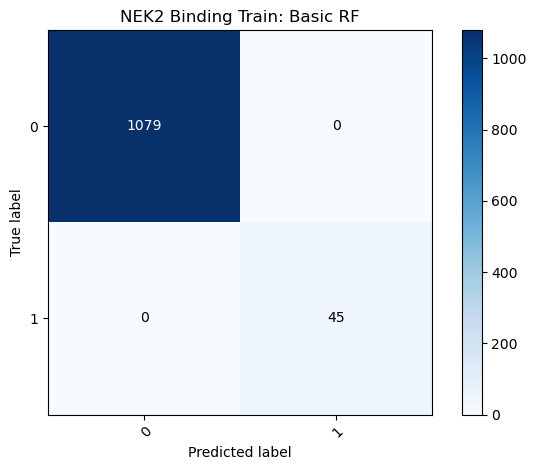

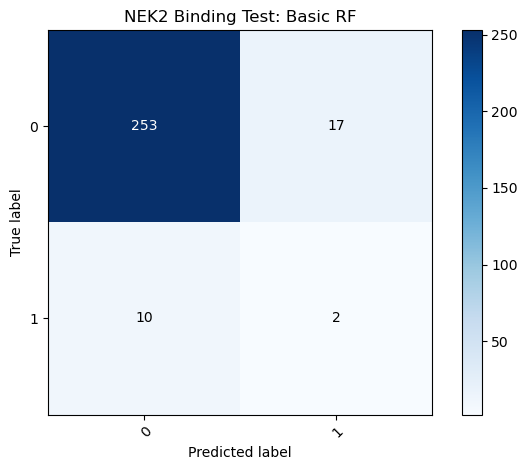

In [42]:
rf_basic100est = rf_models(train_x, train_y, test_x, test_y, 'basic RF', {}, 'binding')
plot_confusion_matrix(train_y, rf_basic100est['train_pred'], ['0','1'], title='NEK2 Binding Train: Basic RF')
plot_confusion_matrix(test_y, rf_basic100est['test_pred'], ['0','1'], title='NEK2 Binding Test: Basic RF')

In [43]:
for param,value in rf_basic100est['model'].get_params().items(): 
    print(f'{param}: {value}')

bootstrap: False
ccp_alpha: 0.0
class_weight: None
criterion: gini
max_depth: 100
max_features: None
max_leaf_nodes: None
max_samples: None
min_impurity_decrease: 0.0
min_samples_leaf: 1
min_samples_split: 2
min_weight_fraction_leaf: 0.0
n_estimators: 100
n_jobs: None
oob_score: False
random_state: None
verbose: 0
warm_start: False


In [15]:
fn_basic  = (test_y == 1) & (rf_basic100est['test_pred'] == 0)
results_fn  = test_x[fn_basic]
fn_indicies  = np.where(fn_basic)
fn_indicies

(array([271, 272, 273, 274, 275, 277, 279, 280, 281, 282]),)

In [7]:
max_depths = [20,50,100]
n_estimators = [100,200,500]
max_features = [50,100,300]

In [11]:

# rf_plots(train_x, train_y, test_x, test_y, max_depths, n_estimators, max_features, 'basic RF', parameters={}, dataset_type='binding')

# Reduced param grid for grid search - RUN IN BASH SCRIPT 

In [4]:
param_grid = {
    'n_estimators': np.linspace(100, 2000, 3, dtype = int),
    'max_depth': [20, 100, 200, 220],
    'min_samples_split': [2, 4],
    'min_samples_leaf': [2, 5],
    'criterion': ['gini','entropy']
}

In [5]:
save_file = 'atom_nek2bind_rf_basic_best.pkl'
# rf_basicbest = find_best_models(train_x, train_y, test_x, test_y, 'basic RF', {}, param_grid,  save_file, 2)


In [6]:
# with open(save_file, 'wb') as f:
#     pickle.dump(rf_basicbest['best_model'], f)

TRAIN: accuracy: 0.974, precision: 0.786, recall: 0.489, specificity: 0.994
TEST: accuracy: 0.947, precision: 0.000, recall: 0.000, specificity: 0.989
bootstrap: False
ccp_alpha: 0.0
class_weight: None
criterion: gini
max_depth: 20
max_features: None
max_leaf_nodes: None
max_samples: None
min_impurity_decrease: 0.0
min_samples_leaf: 5
min_samples_split: 4
min_weight_fraction_leaf: 0.0
n_estimators: 1050
n_jobs: None
oob_score: False
random_state: None
verbose: 0
warm_start: False


<Figure size 600x400 with 0 Axes>

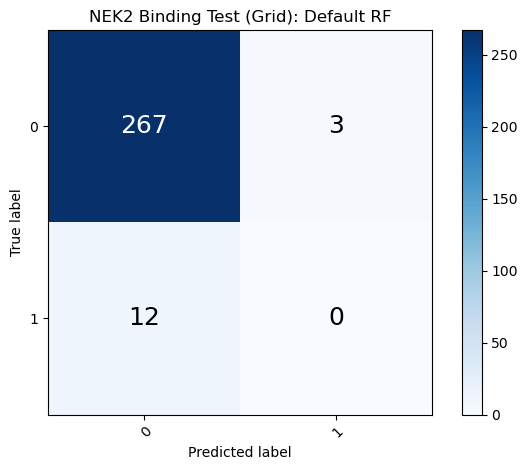

In [9]:
with open('saved_models/atom_nek2bind_rf_basic_best.pkl', 'rb') as f: 
    rf_basic_best = pickle.load(f) 

results_basic = rf_results2(rf_basic_best, train_x, train_y, test_x, test_y)
plot_confusion_matrix(test_y,results_basic['test_pred'], ['0','1'], title='NEK2 Binding Test (Grid): Default RF')
for param,value in rf_basic_best.get_params().items(): 
    print(f'{param}: {value}')


In [37]:
# save_model(rf_basicbest['best_model'], save_file)

# Basic RF + classweight balanced 

TRAIN: accuracy: 1.000, precision: 1.000, recall: 1.000, sensitivity: 1.000, specificity: 1.000
TEST: accuracy: 0.936, precision: 0.125, recall: 0.083, sensitivity: 0.083, specificity: 0.974


<Figure size 600x400 with 0 Axes>

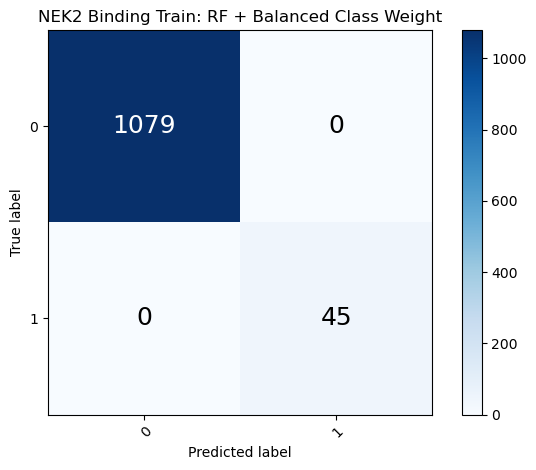

<Figure size 600x400 with 0 Axes>

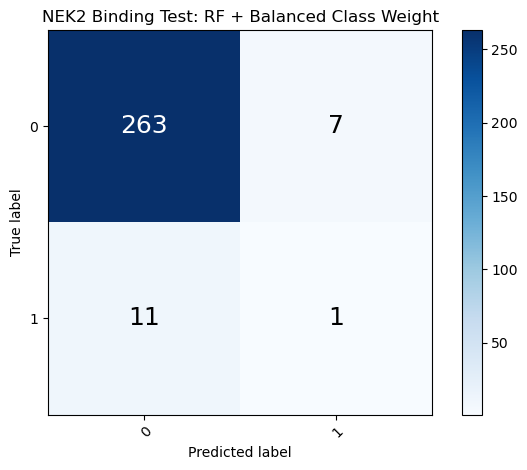

In [72]:
brf_model_BCW = rf_models(train_x, train_y, test_x, test_y, 'balanced class_weight', {}, 'binding')
plot_confusion_matrix(train_y, brf_model_BCW['train_pred'], ['0','1'], title='NEK2 Binding Train: RF + Balanced Class Weight')
plot_confusion_matrix(test_y, brf_model_BCW['test_pred'], ['0','1'], title='NEK2 Binding Test: RF + Balanced Class Weight')

In [73]:
for param,value in brf_model_BCW['model'].get_params().items(): 
    print(f'{param}: {value}')

bootstrap: False
ccp_alpha: 0.0
class_weight: balanced
criterion: gini
max_depth: 100
max_features: None
max_leaf_nodes: None
max_samples: None
min_impurity_decrease: 0.0
min_samples_leaf: 1
min_samples_split: 2
min_weight_fraction_leaf: 0.0
n_estimators: 100
n_jobs: None
oob_score: False
random_state: None
verbose: 0
warm_start: False


In [10]:
save_file2 = 'atom_nek2bind_rf_basicBCW_best.pkl'
# rf_basicBCWbest = find_best_models(train_x, train_y, test_x, test_y, 'balanced class_weight', {}, param_grid,  save_file2, 2)
# save_model(rf_basicBCWbest['best_model'], save_file2)



In [11]:
# with open(save_file2, 'wb') as f:
#     pickle.dump(rf_basicBCWbest['best_model'], f)

TRAIN: accuracy: 0.998, precision: 0.957, recall: 1.000, specificity: 0.998
TEST: accuracy: 0.940, precision: 0.222, recall: 0.167, specificity: 0.974
bootstrap: False
ccp_alpha: 0.0
class_weight: balanced
criterion: gini
max_depth: 100
max_features: None
max_leaf_nodes: None
max_samples: None
min_impurity_decrease: 0.0
min_samples_leaf: 2
min_samples_split: 2
min_weight_fraction_leaf: 0.0
n_estimators: 100
n_jobs: None
oob_score: False
random_state: None
verbose: 0
warm_start: False


<Figure size 600x400 with 0 Axes>

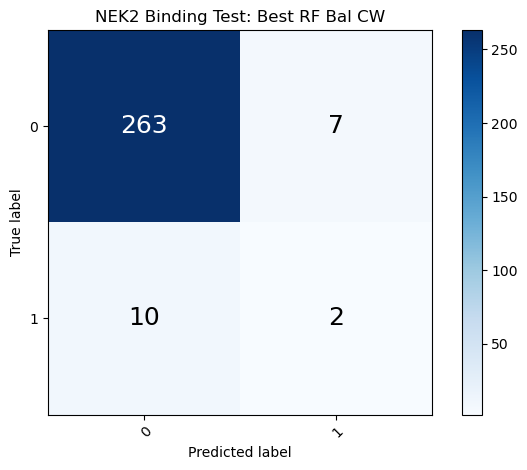

In [12]:
with open('saved_models/'+save_file2, 'rb') as f: 
    rf_basicBCWbestmodel = pickle.load(f) 

rf_bcw_results = rf_results2(rf_basicBCWbestmodel, train_x, train_y, test_x, test_y)
plot_confusion_matrix(test_y, rf_bcw_results['test_pred'], ['0','1'], title='NEK2 Binding Test: Best RF Bal CW')
for param,value in rf_basicBCWbestmodel.get_params().items(): 
    print(f'{param}: {value}')



# Balanced Random Forest Classifier

TRAIN: accuracy: 1.000, precision: 1.000, recall: 1.000, sensitivity: 1.000, specificity: 1.000
TEST: accuracy: 0.904, precision: 0.105, recall: 0.167, sensitivity: 0.167, specificity: 0.937


<Axes: title={'center': 'NEK2 Binding Test: Balanced RFC'}, xlabel='Predicted label', ylabel='True label'>

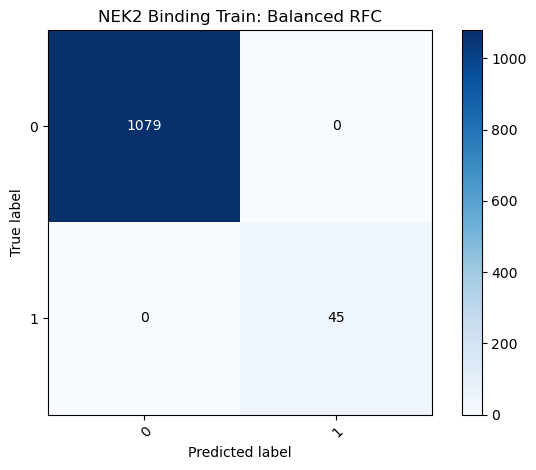

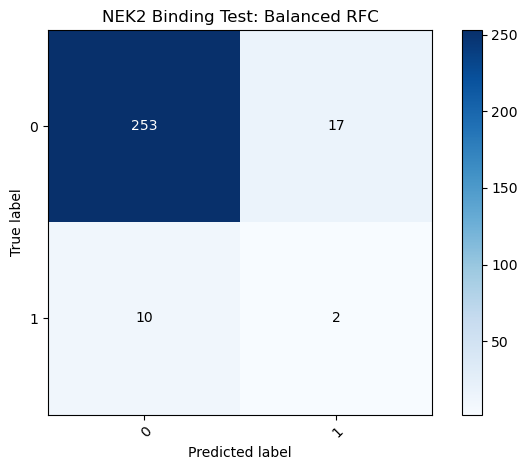

In [47]:
brf_model = rf_models(train_x, train_y, test_x, test_y, 'BalancedRandomForestClassifier', {}, 'binding')
plot_confusion_matrix(train_y, brf_model['train_pred'], ['0','1'], title='NEK2 Binding Train: Balanced RFC')
plot_confusion_matrix(test_y, brf_model['test_pred'], ['0','1'], title='NEK2 Binding Test: Balanced RFC')

In [26]:
for param,value in brf_model['model'].get_params().items(): 
    print(f'{param}: {value}')

bootstrap: False
ccp_alpha: 0.0
class_weight: None
criterion: gini
max_depth: 100
max_features: None
max_leaf_nodes: None
max_samples: None
min_impurity_decrease: 0.0
min_samples_leaf: 1
min_samples_split: 2
min_weight_fraction_leaf: 0.0
n_estimators: 100
n_jobs: None
oob_score: False
random_state: None
verbose: 0
warm_start: False


In [13]:
save_file3 = 'atom_nek2bind_BRFC_best.pkl'
# brfc_best = find_best_models(train_x, train_y, test_x, test_y, 'BalancedRandomForestClassifier', {}, param_grid,  save_file3, 2)
# save_model(brfc_best['best_model'], save_file3)

# with open(save_file3, 'wb') as f:
#     pickle.dump(brfc_best['best_model'], f)

TRAIN: accuracy: 0.974, precision: 0.786, recall: 0.489, specificity: 0.994
TEST: accuracy: 0.947, precision: 0.000, recall: 0.000, specificity: 0.989
bootstrap: False
ccp_alpha: 0.0
class_weight: None
criterion: gini
max_depth: 20
max_features: None
max_leaf_nodes: None
max_samples: None
min_impurity_decrease: 0.0
min_samples_leaf: 5
min_samples_split: 4
min_weight_fraction_leaf: 0.0
n_estimators: 100
n_jobs: None
oob_score: False
random_state: None
verbose: 0
warm_start: False


<Figure size 600x400 with 0 Axes>

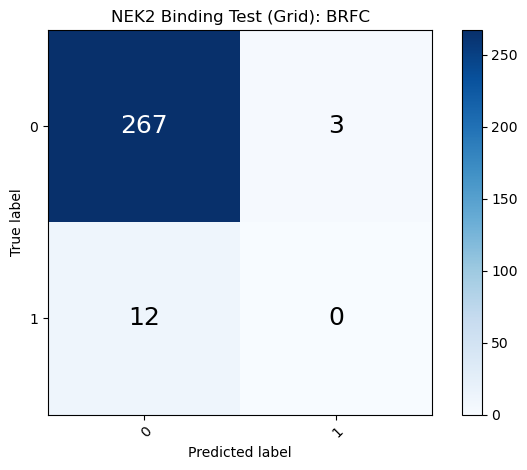

In [15]:
with open('saved_models/'+save_file3, 'rb') as f: 
    brfc_best = pickle.load(f) 
brfc_results = rf_results2(brfc_best, train_x, train_y, test_x, test_y)
plot_confusion_matrix(test_y, brfc_results['test_pred'], ['0','1'], title='NEK2 Binding Test (Grid): BRFC')
for param,value in brfc_best.get_params().items(): 
    print(f'{param}: {value}')

# Try BRFC with balanced class weight & bootstrap

TRAIN: accuracy: 1.000, precision: 1.000, recall: 1.000, sensitivity: 1.000, specificity: 1.000
TEST: accuracy: 0.936, precision: 0.125, recall: 0.083, sensitivity: 0.083, specificity: 0.974


<Axes: title={'center': 'NEK2 Binding Test: Balanced RFC + Balanced Class Weight'}, xlabel='Predicted label', ylabel='True label'>

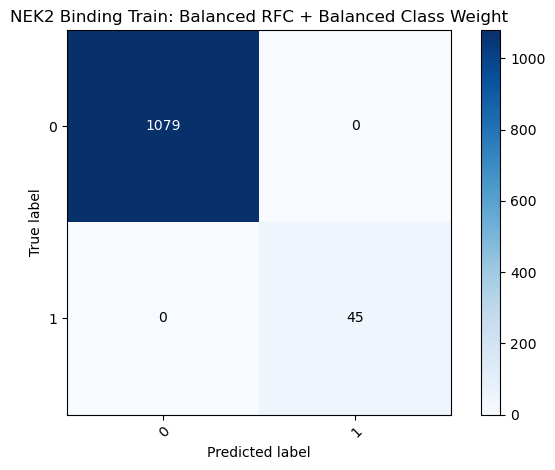

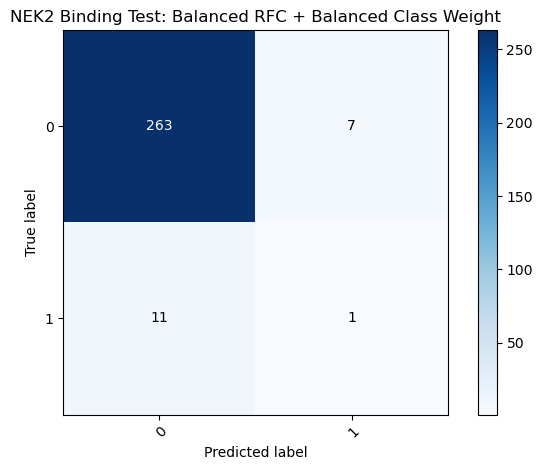

In [50]:
brf_modelCWB = rf_models(train_x, train_y, test_x, test_y, 'BalancedRandomForestClassifier', {'class_weight':'balanced', 'bootstrape':'True'}, 'binding')
plot_confusion_matrix(train_y, brf_modelCWB['train_pred'], ['0','1'], title='NEK2 Binding Train: Balanced RFC + Balanced Class Weight')
plot_confusion_matrix(test_y, brf_modelCWB['test_pred'], ['0','1'], title='NEK2 Binding Test: Balanced RFC + Balanced Class Weight')

In [79]:
for param,value in brf_modelCWB['model'].get_params().items(): 
    print(f'{param}: {value}')

NameError: name 'brf_modelCWB' is not defined

TRAIN: accuracy: 0.998, precision: 0.957, recall: 1.000, specificity: 0.998
TEST: accuracy: 0.940, precision: 0.143, recall: 0.083, specificity: 0.978
bootstrap: False
ccp_alpha: 0.0
class_weight: balanced
criterion: gini
max_depth: 100
max_features: None
max_leaf_nodes: None
max_samples: None
min_impurity_decrease: 0.0
min_samples_leaf: 2
min_samples_split: 2
min_weight_fraction_leaf: 0.0
n_estimators: 100
n_jobs: None
oob_score: False
random_state: None
verbose: 0
warm_start: False


<Figure size 600x400 with 0 Axes>

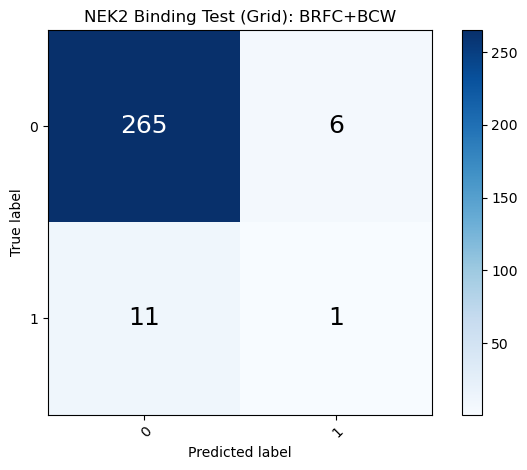

In [62]:
save_file4 = 'atom_nek2bind_BRFC_BCW_best.pkl'
# brfc_BCW_best = find_best_models(train_x, train_y, test_x, test_y, 'BalancedRandomForestClassifier', {'class_weight':'balanced', 'bootstrape':'True'}, param_grid,  save_file4, 2)
# save_model(brfc_BCW_best['best_model'], save_file4)
# with open(save_file4, 'wb') as f:
#     pickle.dump(brfc_BCW_best['best_model'], f)
# with open(save_file4, 'rb') as f: 
#     brfc_BCW_best = pickle.load(f) 

with open('saved_models/'+save_file4, 'rb') as f: 
    brfc_bcw_best = pickle.load(f) 
brfc_bcw_best_results = rf_results2(brfc_bcw_best, train_x, train_y, test_x, test_y)
plot_confusion_matrix(test_y, brfc_bcw_best_results['test_pred'], ['0','1'], title='NEK2 Binding Test (Grid): BRFC+BCW')
for param,value in brfc_bcw_best.get_params().items(): 
    print(f'{param}: {value}')



In [23]:
# max depth was default 1-- 
# temp_nek2bind_MOE_original = {'default_RF':rf_basic100est['model'], 'rf_bcw':brf_model_BCW['model'],
#                               'BRFC': brf_model['model'], 'BRFC_bcw':brf_modelCWB['model']}

# with open('temp_nek2bind_originalmodels.pkl', 'wb') as f:
#     pickle.dump(temp_nek2bind_MOE_original, f)
# with open('temp_nek2bind_originalmodels.pkl', 'rb') as f: 
#     temp_dict = pickle.load(f)

In [17]:
nek2bind_scaledmodels = {'default_RF':rf_basic_best, 'rf_bcw':rf_basicBCWbestmodel,
                              'BRFC': brfc_best, 'BRFC_bcw':brfc_bcw_best}

# with open('nek2bind_originalmodels.pkl', 'wb') as f:
#     pickle.dump(nek2bind_scaledmodels, f)


In [63]:
grid_models = [rf_basic_best, rf_basicBCWbestmodel,brfc_best,brfc_bcw_best]
model_dictionaries = []
for i, model in enumerate(grid_models): 
    train_results = save_rf_results(model, train_x, train_y)
    test_results  = save_rf_results(model, test_x, test_y) 
    model_dict = {'model':model, 'train_results':train_results, 'test_results':test_results}
    model_dictionaries.append(model_dict) 

# with open('nek2_bind_original_results.pkl', 'wb') as f:
#     pickle.dump(model_dictionaries, f)

In [38]:
tree_probs = np.array([tree.predict_proba(train_x)[:,1] for tree in brfc_bcw_best.estimators_])
tree_probs

array([[0., 0., 0., ..., 1., 1., 1.],
       [0., 0., 0., ..., 1., 1., 1.],
       [0., 0., 0., ..., 1., 1., 1.],
       ...,
       [0., 0., 0., ..., 1., 1., 1.],
       [0., 0., 0., ..., 1., 1., 1.],
       [0., 0., 0., ..., 1., 1., 1.]])

In [19]:
train_prob0 = brfc_bcw_best.predict_proba(train_x)[:,0]
train_prob1 = brfc_bcw_best.predict_proba(train_x)[:,1]
train_prob0std = brfc_bcw_best.predict_proba(train_x)[:,0].std(axis=0)
train_prob1std = brfc_bcw_best.predict_proba(train_x)[:,1].std(axis=0)
train_prob1std

test_prob0 = brfc_bcw_best.predict_proba(test_x)[:,0]
test_prob1 = brfc_bcw_best.predict_proba(test_x)[:,1]
test_prob0std = brfc_bcw_best.predict_proba(test_x)[:,0].std(axis=0)
test_prob1std = brfc_bcw_best.predict_proba(test_x)[:,1].std(axis=0)
test_prob1std

0.19792045551448195

In [53]:
def plot_prob(prob_class0, prob_class1, title, bind_inhib):
    """Histogram of probabilities for each class
    prob_class0: probabilities for class 0.
    prob_class1: probabilities for class 1.
    """
    fig_width = 10
    fig_height = 8
    fig, ax = plt.subplots(figsize=(fig_width, fig_height))

    bins = np.linspace(0, 1, 50) 
    ax.hist(prob_class0, bins, alpha=0.5, label=f'(No {bind_inhib})')
    ax.hist(prob_class1, bins, alpha=0.5, label=f'{bind_inhib}')

    ax.set_xlabel('Probability')
    ax.set_ylabel('Frequency')
    plt.title(title, fontsize=24)
    plt.legend(loc='upper center', fontsize=18)
    plt.grid(True)
    plt.title(title)
    plt.show();

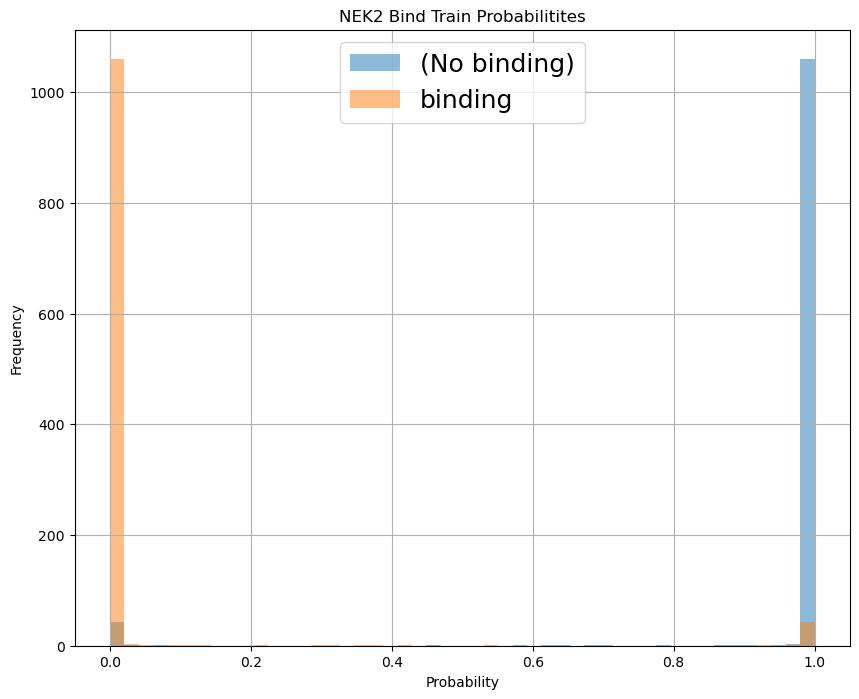

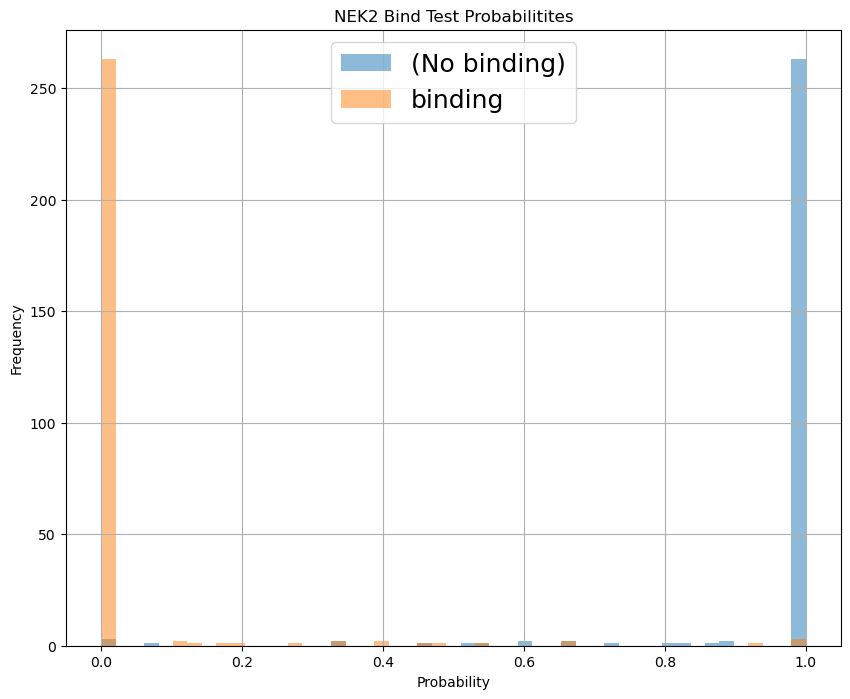

In [54]:
plot_prob(train_prob0, train_prob1, 'NEK2 Bind Train Probabilitites', 'binding')
plot_prob(test_prob0, test_prob1, 'NEK2 Bind Test Probabilitites', 'binding')

/Users/jayceepang/miniconda3/envs/atom2024/lib/python3.9/site-packages/seaborn/categorical.py:3399: UserWarning: 94.3% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/Users/jayceepang/miniconda3/envs/atom2024/lib/python3.9/site-packages/seaborn/categorical.py:3399: UserWarning: 26.7% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/Users/jayceepang/miniconda3/envs/atom2024/lib/python3.9/site-packages/seaborn/categorical.py:3399: UserWarning: 95.3% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


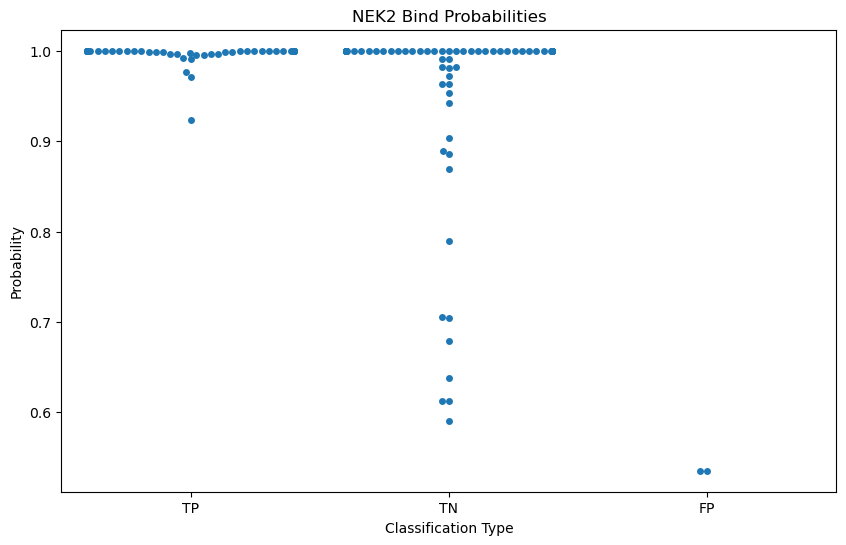

In [64]:
swarm_prob(brfc_bcw_best, train_x, train_y, 'NEK2 Bind Probabilities')

/Users/jayceepang/miniconda3/envs/atom2024/lib/python3.9/site-packages/seaborn/categorical.py:3399: UserWarning: 86.7% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/Users/jayceepang/miniconda3/envs/atom2024/lib/python3.9/site-packages/seaborn/categorical.py:3399: UserWarning: 88.3% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


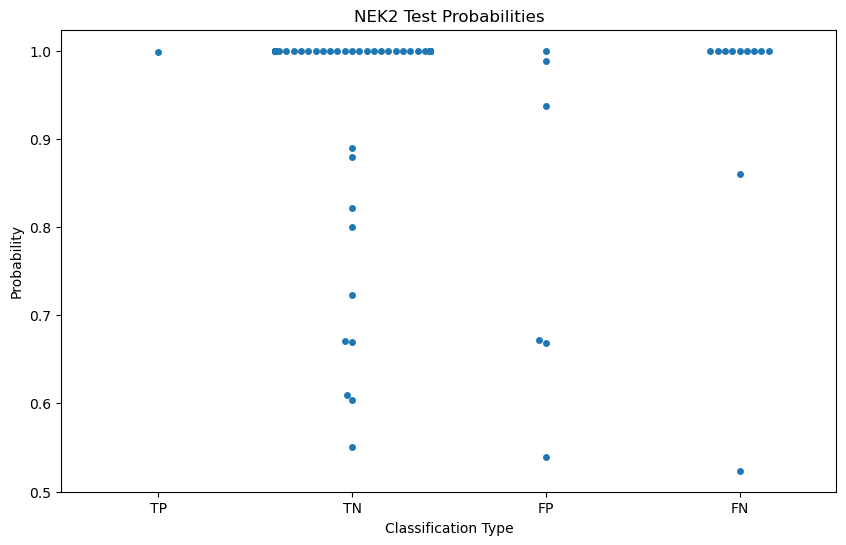

In [62]:
swarm_prob(brfc_bcw_best, test_x, test_y, 'NEK2 Test Probabilities')

In [ ]:
swarm_by_var_and_prob(brfc_bcw_best, test_y, observed_pred, probabilities, title)